In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [ ]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

# set_random_seed(42)

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
df = pd.read_csv("hf://datasets/Ayon128/CB/final_CB_multi-label_dataset.csv")
df.shape

(5089, 8)

In [8]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=5))

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
4315,তোর মতো জঘন্য প্রানী পৃথিবীতে আরেকটা আছে বলে মনে হয় না।,Singer,Male,"Insult, Targeted Harassment",0,1,0,1
278,বেয়াদব এর নাটক সব বর্জন করেন চরিত্রহীন চরম বেয়াদব দুনিয়ায় কিভাবে এসেছে তাও বলতে পারবে না যৌবন জোয়ারে এমন কথাবার্তা বলে,Actor,Female,"Insult, Targeted Harassment",0,1,0,1
3590,চুদমারানী মাগি নাটকের প্রলাপ সব জায়গায় খাটে না? ইসলামের অন্যতম মৌলিক বিষয় আখেরাত বা পরকালের প্রতি বিশ্বাস। তুই মাগি সেটা বিশ্বাস করিস না আবার আল্লাহর নাম নিস।অভিনয় সব জায়গায় খাটে না রে মাগি।এসবের মাধ্যমে নিজেকে আল্ট্রা মডার্ন প্রমাণ করতে চাইছিলো কিন্তু পাবলিক হোগার মধ্যে দিয়ে যে ভরে দিবে সেটা আন্দাজ করতে পারেনি।শালা মূর্খ মাগি।,Actor,Female,"Trolling, Insult, Hate Speech, Targeted Harassment",1,1,1,1
2052,"গরিব মানুষের বিপদের সময়,হিরো আলম কে রাস্তায় দেখা গেছে,আর কোন চেটের বাল কে দেখিনাই,কৌত থেকে জায়েদ মায়েদ এগুলা আসে কে চিনে এগুলা কে,এগুলা হচ্ছে অহংকারী বড় চোর,",Social,Male,"Trolling, Insult, Hate Speech, Targeted Harassment",1,1,1,1
4608,"আমি যা দেখিনা তা বিশ্বাস করি না। সাফা কবিছ-! (নায়ুজবিল্লাহ) -এই শালার বেটি দুঃখিত! এই সেলিব্রিটিকে আমার প্রশ্ন-!-তোমার আব্বু তোমার আম্মুকে বিয়ে করছে সেটা কি তুমি দেখছ মনু?তো বিশ্বাস করবা না কিন্তু বলে দিলাম- সকালে ভীষণ বাসাত হইছে.বাতাস দেখছ নাকি গাছের লাফালাফি দেখছ মনু? তো বাতাস ত দেখো নি? তাইলে বাতাস কে বাতাস না বইলা লাফালাফি বললেই পারো -! মাঝেমধ্যে আম্মু ভীষণ মাথা ব্যথা করছে. এই বইলা ডায়লগ দিও না হে-!কারণ মাথা ব্যথা পেট ব্যথা এসব কিন্তু দেখা যায় না। তোমারে পাশে পাইলে কানের নিছে ঠাসাই থাপ্পড় দিতাম আর জিজ্ঞেস করতাম ব্যথা পাইছ মনু? তখন তুমি কি বলতা মনু-! বলতা আমি কিন্তু কাইন্দা দিমু- কারণ তুমি ব্যথা পাইতা আর সেটাও দেখা যায় না মনু-আরও একটু গবেষণা কর-! আরসঠিক পথে আসো - এসব স্রেলিব্রেটি নামক শালার বেটিদের আমরা আবাল বাঙালিরা মাথায় তাদের কাঙালি হয়ে এত মাথায় তুলছি যে, তারা যা মুখে আসে তাই বলে-",Actor,Female,"Trolling, Insult, Targeted Harassment",1,1,0,1


In [9]:
df.columns

Index(['Comment', 'Profession', 'Gender', 'Labels', 'Trolling', 'Insult',
       'Hate Speech', 'Targeted Harassment'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df, random_state=1, test_size=0.3, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=1, test_size=0.50, shuffle=True)

In [12]:
df_train.shape, df_test.shape, df_valid.shape

((3562, 8), (763, 8), (764, 8))

In [13]:
df_test.head()

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
1720,বাপ জেমন মেয়েত তেমনি হবে এটাতো তাদের রেচালা।,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2702,জুতা মারি তোর চোয়ালে বেটা বেয়াদব । এজন্যই তো ত...,Singer,Female,"Insult, Targeted Harassment",0,1,0,1
4740,"সালা বেগাচেগা তুই লাইভে আসিস কি করতে, আয়নায় কো...",Social,Male,"Trolling, Insult, Targeted Harassment",1,1,0,1
4076,জুতা মার।ছাগলের বাচ্চা,Social,Male,"Insult, Targeted Harassment",0,1,0,1
2445,ওর নোংরা ছবিটা পোস্ট না করে শুধু লেখাটা রাখলেই...,Actor,Female,"Trolling, Insult",1,1,0,0


In [14]:
# checkpoint = "csebuetnlp/banglabert" "sagorsarker/bangla-bert-base" "csebuetnlp/banglabert_large"
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 16
    MODEL_PATH = "csebuetnlp/banglabert"
    LR = 3e-5
    DROPOUT = 0.3
    NUM_CLASSES = 4
    SEED = 42
    MAX_LEN = 128
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [15]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<Axes: ylabel='Count'>

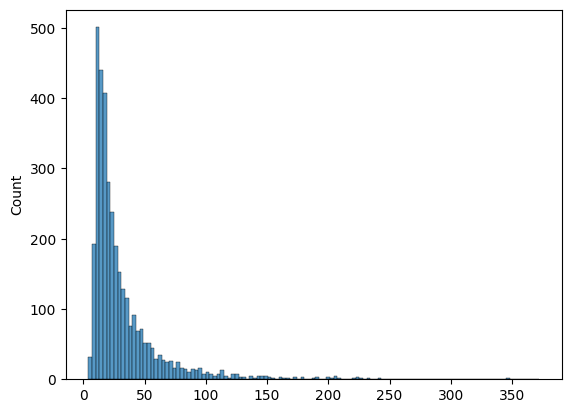

In [16]:
token_counts = []

for _, row in df_train.iterrows():
    text = str(row["Comment"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

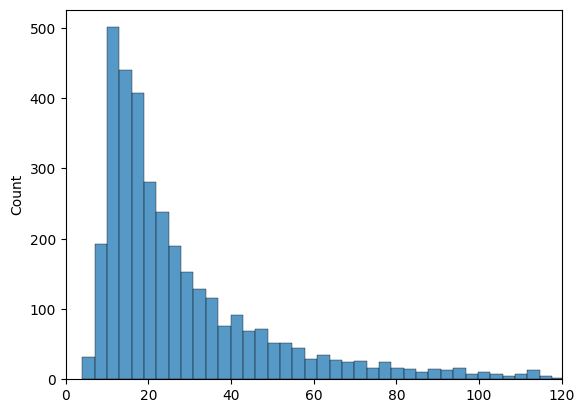

In [17]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

<Axes: ylabel='Count'>

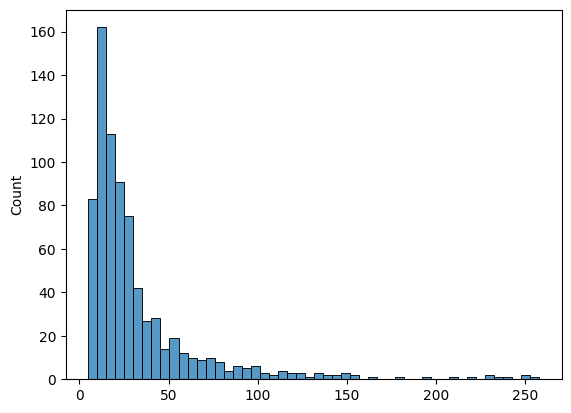

In [18]:
token_counts = []

for _, row in df_valid.iterrows():
    text = str(row["Comment"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

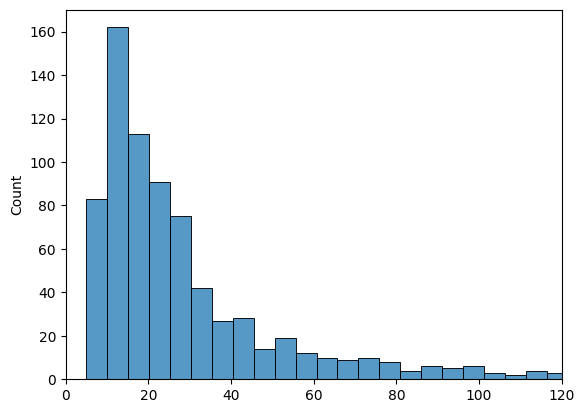

In [19]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

In [20]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer, target_list):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.targets = self.df[target_list].values
        # self.labels = torch.tensor(df.Label.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["Comment"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        # labels = self.labels[index]
        labels = torch.FloatTensor(self.targets[index])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [21]:
target_list = list(df.columns)
target_list

['Comment',
 'Profession',
 'Gender',
 'Labels',
 'Trolling',
 'Insult',
 'Hate Speech',
 'Targeted Harassment']

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
target_list = target_list[4:]

In [24]:
target_list

['Trolling', 'Insult', 'Hate Speech', 'Targeted Harassment']

In [ ]:
class LSTMPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_lstm):
        super(LSTMPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_lstm = hiddendim_lstm
        self.lstm = nn.LSTM(self.hidden_size, self.hiddendim_lstm, batch_first=True)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, all_hidden_states):
        ## forward
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out, _ = self.lstm(hidden_states, None)
        out = self.dropout(out[:, -1, :])
        return out

In [27]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(
            config.MODEL_PATH, 
            config=self.model_config
        )
        # LSTM pooler
        self.lstm_pooler = LSTMPooling(
            self.model_config.num_hidden_layers, 
            self.model_config.hidden_size, 
            768
        )
        
        # Combined dimension: LSTM hidden dim + model hidden size (for CLS token)
        combined_dim = 768 + self.model_config.hidden_size
        
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        # Classifier takes the combined dimension as input
        self.classifier = nn.Linear(combined_dim, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        # Get hidden states from the model
        outputs = self.model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Get all hidden states
        all_hidden_states = outputs.hidden_states
        
        # Get LSTM pooled representation
        lstm_output = self.lstm_pooler(all_hidden_states)
        
        # Get CLS token from the last layer
        cls_output = all_hidden_states[-1][:, 0]
        
        # Concatenate CLS and LSTM outputs
        combined = torch.cat([cls_output, lstm_output], dim=-1)
        
        # Apply dropout and classifier
        output_dropout = self.dropout(combined)
        output = self.classifier(output_dropout)
        
        return output

In [48]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        y_pred = torch.sigmoid(pred).cpu().detach().numpy().round()
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [49]:
# Run training function with improved training procedure
from transformers import get_cosine_schedule_with_warmup
history = defaultdict(list)
def run_training(save_model = False):
    train_dataset = ClassifierDataset(df_train, tokenizer, target_list)
    valid_dataset = ClassifierDataset(df_valid, tokenizer, target_list)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE,
        collate_fn=data_collator, 
        shuffle=True, 
        num_workers=2
    )    
    
    val_loader = DataLoader(
        valid_dataset, 
        batch_size=config.BATCH_SIZE,
        collate_fn=data_collator, 
        shuffle=False, 
        num_workers=2
    )   
    
    set_random_seed(config.SEED)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    # Use differential learning rates
    optimizer_grouped_parameters = [
        # BanglaBERT parameters
        {
            'params': [p for n, p in model.named_parameters() if 'model' in n],
            'lr': config.LR,
            'weight_decay': 0.01
        },
        # Task-specific parameters (including LSTM)
        {
            'params': [p for n, p in model.named_parameters() if 'model' not in n],
            'lr': config.LR * 3,  # Higher learning rate for task-specific layers
            'weight_decay': 0.01
        }
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    warmup_steps = int(0.1 * num_training_steps) 
    
    # Use cosine scheduler with warmup
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )
    
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader, scaler, num_training_steps)
        val_score, val_loss = eng.evaluate(val_loader)
        
        print(f"Epoch: {epoch + 1} | Training_loss: {round(train_loss, 4)} | Val_loss: {round(val_loss, 4)} | Val_f1: {round(val_score, 4)}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(), f"banglabert_cyberbullying_model.bin")
                print(f"Saved new best model with F1: {round(val_score, 4)}")
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter > early_stopping_iter:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
            
    del model
    gc.collect()
            
    return round(best_score, 5), history

In [51]:
score =run_training(save_model = True)
print(f"Best f1 Score: {score}")

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 0.648 | Val_loss: 0.625 | Val_f1: 0.4302
Saved new best model with F1: 0.4302


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 0.5577 | Val_loss: 0.5251 | Val_f1: 0.772
Saved new best model with F1: 0.772


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 0.4336 | Val_loss: 0.4283 | Val_f1: 0.8223
Saved new best model with F1: 0.8223


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.3639 | Val_loss: 0.4157 | Val_f1: 0.8234
Saved new best model with F1: 0.8234


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.3236 | Val_loss: 0.4005 | Val_f1: 0.8342
Saved new best model with F1: 0.8342


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.2856 | Val_loss: 0.4108 | Val_f1: 0.8318


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.2646 | Val_loss: 0.4234 | Val_f1: 0.8354
Saved new best model with F1: 0.8354


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4a5ab6170>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4a5ab6170>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Epoch: 8 | Training_loss: 0.2235 | Val_loss: 0.3985 | Val_f1: 0.8492
Saved new best model with F1: 0.8492


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.1893 | Val_loss: 0.4197 | Val_f1: 0.8425


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.1644 | Val_loss: 0.4432 | Val_f1: 0.8435


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 11 | Training_loss: 0.1448 | Val_loss: 0.4409 | Val_f1: 0.842


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 12 | Training_loss: 0.1343 | Val_loss: 0.4707 | Val_f1: 0.8417


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4a5ab6170><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4a5ab6170>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Epoch: 13 | Training_loss: 0.1165 | Val_loss: 0.4633 | Val_f1: 0.8449


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 14 | Training_loss: 0.1134 | Val_loss: 0.462 | Val_f1: 0.8461
Early stopping triggered after 14 epochs
Best f1 Score: (0.8492, defaultdict(<class 'list'>, {'train_loss': [0.6480141549367007, 0.5577246822049265, 0.4336054727368291, 0.3638804552266416, 0.32359223027667655, 0.28564858964473144, 0.26464319229125977, 0.22351078221348902, 0.18932486385641611, 0.16435085009833622, 0.1447814361530569, 0.13433102474886205, 0.11649886782661147, 0.11340192772214189], 'val_loss': [0.6250484213232994, 0.52507165633142, 0.428349203740557, 0.41570674255490303, 0.40052022722860176, 0.4107814949626724, 0.42342506907880306, 0.39854567870497704, 0.41967057312528294, 0.4432432170336445, 0.4408862066144745, 0.47074339787165326, 0.4633147989710172, 0.46196785538146895]}))


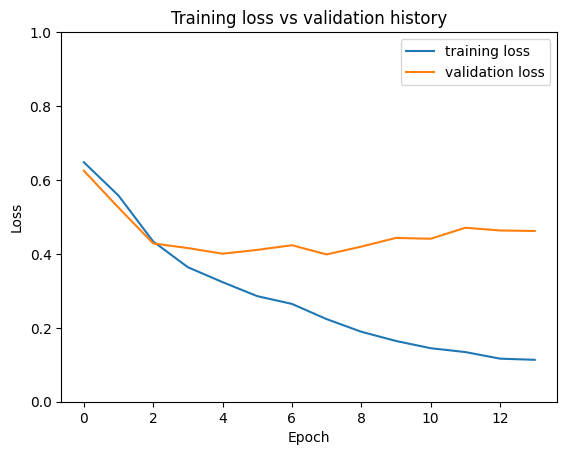

In [52]:
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training loss vs validation history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [28]:
 model = ClassifierModel()

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [29]:
model_path = f"/kaggle/working/banglabert_cyberbullying_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
from huggingface_hub import HfApi, create_repo
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

# Step 1: Create the repository first
repo_id = "Ayon128/banglabert-cyberbullying"
create_repo(repo_id, token=hf_token, repo_type="model", exist_ok=True)
print(f"✅ Repository created: {repo_id}")

api = HfApi(token=hf_token)
api.upload_file(
    path_or_fileobj="/kaggle/working/banglabert_cyberbullying_model.bin",
    path_in_repo="banglabert_cyberbullying_model.bin",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

print("✅ Model uploaded successfully!")
print(f"View at: https://huggingface.co/{repo_id}")

✅ Repository created: Ayon128/banglabert-cyberbullying


banglabert_cyberbullying_model.bin:   0%|          | 0.00/459M [00:00<?, ?B/s]

✅ Model uploaded successfully!
View at: https://huggingface.co/Ayon128/banglabert-cyberbullying


In [ ]:
model.to(config.DEVICE);

In [31]:
test_dataset = ClassifierDataset(df_test, tokenizer, target_list)

In [32]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset, batch_size=64, collate_fn=data_collator, shuffle=False
)

In [33]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()

    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        input_ids = data["input_ids"].to(config.DEVICE)
        attention_mask = data["attention_mask"].to(config.DEVICE)
        targets = data["labels"].to(config.DEVICE)
        
        outputs = model(input_ids, attention_mask)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return  predictions, prediction_probs, target_values


In [34]:
predictions, prediction_probs, target_values = get_predictions(model, test_dataloader)

In [35]:
predictions= predictions.numpy()
predictions

array([[1., 1., 0., 0.],
       [0., 1., 0., 1.],
       [1., 1., 0., 1.],
       ...,
       [1., 0., 1., 1.],
       [1., 1., 0., 0.],
       [0., 1., 1., 0.]], dtype=float32)

In [36]:
print(f"\npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")
     


predictions:(763, 4) 
prediction_probs:torch.Size([763, 4]) 
target_values:torch.Size([763, 4])


In [37]:
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report with 4 decimal digits
print(classification_report(target_values, predictions, target_names=target_list, digits=4))

                     precision    recall  f1-score   support

           Trolling     0.8209    0.8234    0.8221       334
             Insult     0.9168    0.9227    0.9197       621
        Hate Speech     0.8851    0.8190    0.8507       348
Targeted Harassment     0.8752    0.9043    0.8895       512

          micro avg     0.8813    0.8793    0.8803      1815
          macro avg     0.8745    0.8673    0.8705      1815
       weighted avg     0.8813    0.8793    0.8800      1815
        samples avg     0.8823    0.8850    0.8689      1815



In [38]:
subset_acc = (predictions == target_values).all(dim=1).float().mean().item()
print(f"Subset Accuracy: {subset_acc:.4f}")


Subset Accuracy: 0.5780


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report with 4 decimal digits
print(classification_report(target_values, predictions, target_names=target_list, digits=4))

                     precision    recall  f1-score   support

           Trolling     0.8209    0.8234    0.8221       334
             Insult     0.9168    0.9227    0.9197       621
        Hate Speech     0.8851    0.8190    0.8507       348
Targeted Harassment     0.8752    0.9043    0.8895       512

          micro avg     0.8813    0.8793    0.8803      1815
          macro avg     0.8745    0.8673    0.8705      1815
       weighted avg     0.8813    0.8793    0.8800      1815
        samples avg     0.8823    0.8850    0.8689      1815



In [40]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

f1 = f1_score(target_values.numpy(), predictions, average='macro')
print(f"F1 Score (macro): {f1:.4f}")
precision = precision_score(target_values, predictions, average='macro')
print(f"Precision (Macro): {precision:.4f}")

# Recall
recall = recall_score(target_values, predictions, average='macro')
print(f"Recall (Macro): {recall:.4f}")

F1 Score (macro): 0.8705
Precision (Macro): 0.8745
Recall (Macro): 0.8673


In [41]:
f1 = f1_score(target_values.numpy(), predictions, average='micro')
print(f"F1 Score (micro): {f1:.4f}")

F1 Score (micro): 0.8803


In [43]:
predictions = torch.tensor(predictions)

# Ensure both are float tensors
predictions = predictions.float()
target_values = target_values.float()

# Hamming Accuracy
hamming_acc = (predictions == target_values).float().mean().item()
print(f"Hamming Accuracy: {hamming_acc:.4f}")

# Hamming Loss
hamming_loss = (predictions != target_values).float().mean().item()
print(f"Hamming Loss: {hamming_loss:.4f}")


Hamming Accuracy: 0.8578
Hamming Loss: 0.1422


In [45]:
df = df_test

In [46]:
df["Pred_Trolling"] = predictions[:, 0]
df["Pred_Insult"] = predictions[:, 1]
df["Pred_Hate_Speech"] = predictions[:, 2]
df["Pred_Targeted_Harassment"] = predictions[:, 3]
cols_to_convert = [
    "Trolling", "Insult", "Hate Speech", "Targeted Harassment",
    "Pred_Trolling", "Pred_Insult", "Pred_Hate_Speech", "Pred_Targeted_Harassment"
]

df[cols_to_convert] = df[cols_to_convert].astype(int)

keep_cols = [
    "Trolling", "Insult", "Hate Speech", "Targeted Harassment",
    "Pred_Trolling", "Pred_Insult", "Pred_Hate_Speech", "Pred_Targeted_Harassment"
]

df_clean = df[keep_cols]
df_clean.to_csv("true_pred_only_seed(42).csv", index=False)

print("Saved: true_pred_only.csv")
df_clean.head()


Saved: true_pred_only.csv


,Trolling,Insult,Hate Speech,Targeted Harassment,Pred_Trolling,Pred_Insult,Pred_Hate_Speech,Pred_Targeted_Harassment
1720,0,1,1,1,1,1,0,0
2702,0,1,0,1,0,1,0,1
4740,1,1,0,1,1,1,0,1
4076,0,1,0,1,0,1,0,1
2445,1,1,0,0,1,0,0,1


In [89]:
df.head()

,id,predicted_labels,actual_labels,macro_f1_score
0,0,"Trolling, Insult","Insult, Hate Speech, Targeted Harassment",0.25
1,1,"Insult, Targeted Harassment","Insult, Targeted Harassment",0.50
2,2,"Trolling, Insult, Targeted Harassment","Trolling, Insult, Targeted Harassment",0.75
3,3,"Insult, Targeted Harassment","Insult, Targeted Harassment",0.50
4,4,"Trolling, Targeted Harassment","Trolling, Insult",0.25


In [90]:
df_test.head()

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
1720,বাপ জেমন মেয়েত তেমনি হবে এটাতো তাদের রেচালা।,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2702,জুতা মারি তোর চোয়ালে বেটা বেয়াদব । এজন্যই তো ত...,Singer,Female,"Insult, Targeted Harassment",0,1,0,1
4740,"সালা বেগাচেগা তুই লাইভে আসিস কি করতে, আয়নায় কো...",Social,Male,"Trolling, Insult, Targeted Harassment",1,1,0,1
4076,জুতা মার।ছাগলের বাচ্চা,Social,Male,"Insult, Targeted Harassment",0,1,0,1
2445,ওর নোংরা ছবিটা পোস্ট না করে শুধু লেখাটা রাখলেই...,Actor,Female,"Trolling, Insult",1,1,0,0


Each label accuracy: 
Trolling
Accuracy: 0.8440
Precision: 0.8209
Recall: 0.8234
F1 Score: 0.8221
-------------------
Insult
Accuracy: 0.8689
Precision: 0.9168
Recall: 0.9227
F1 Score: 0.9197
-------------------
Hate Speech
Accuracy: 0.8689
Precision: 0.8851
Recall: 0.8190
F1 Score: 0.8507
-------------------
Targeted Harassment
Accuracy: 0.8493
Precision: 0.8752
Recall: 0.9043
F1 Score: 0.8895
-------------------


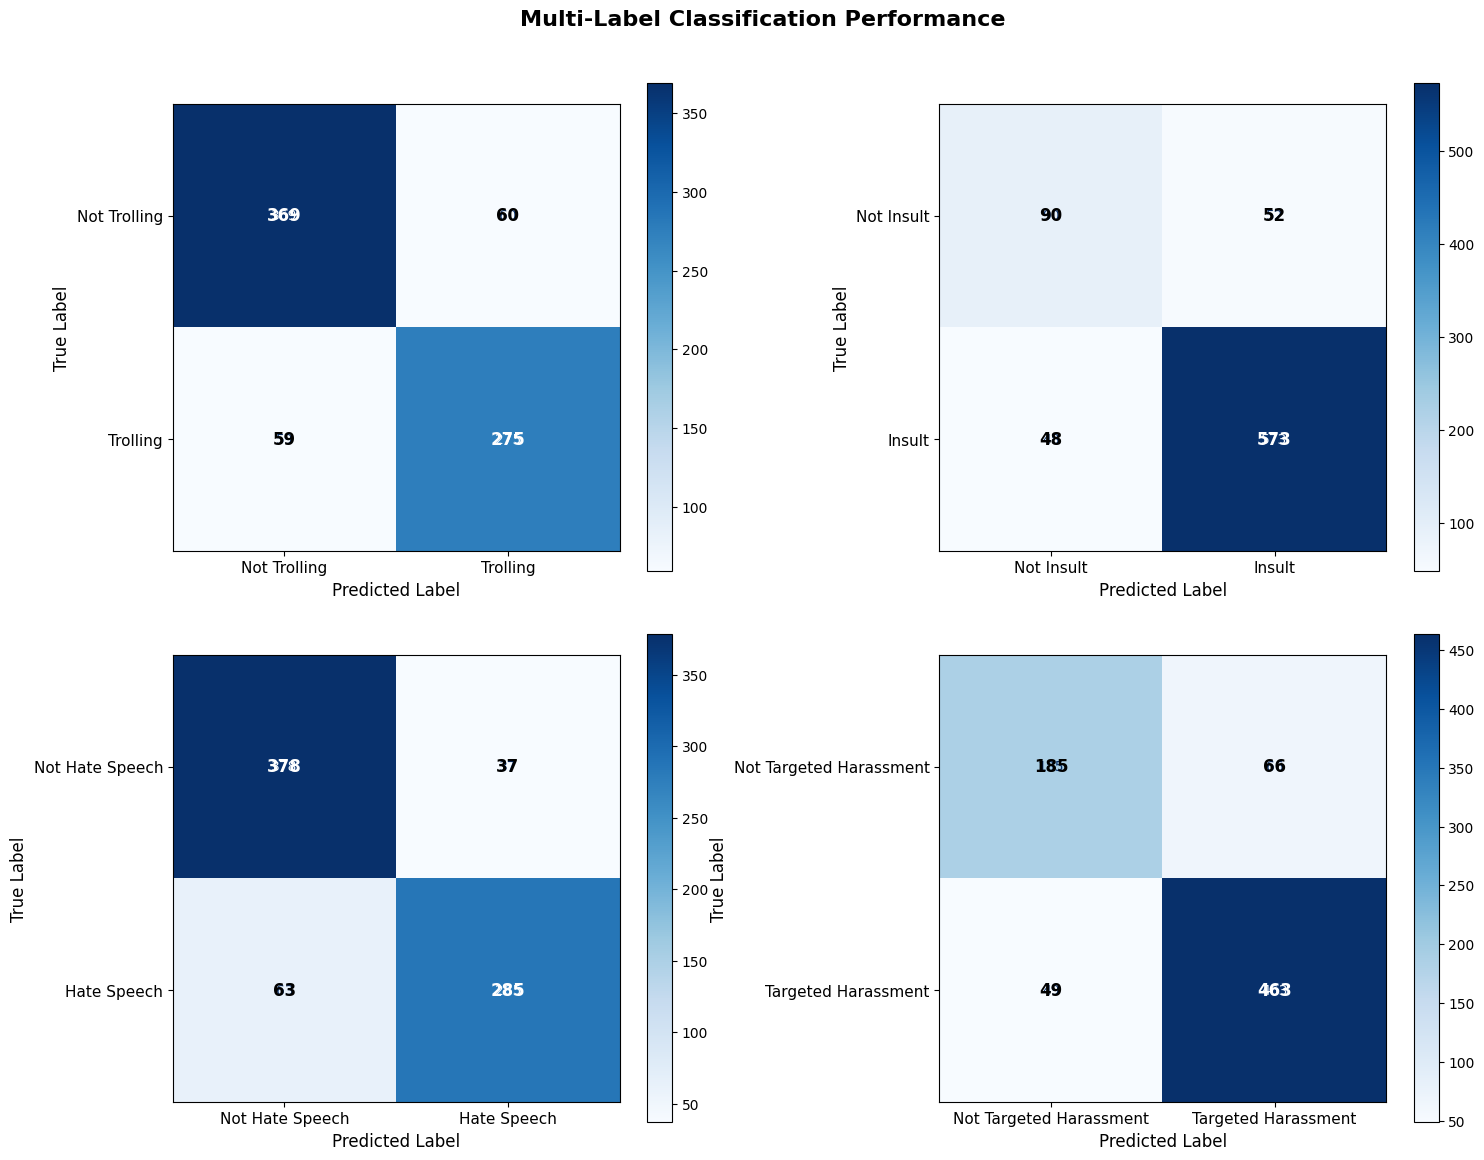


Classification Report:
                     precision    recall  f1-score   support

           Trolling       0.82      0.82      0.82       334
             Insult       0.92      0.92      0.92       621
        Hate Speech       0.89      0.82      0.85       348
Targeted Harassment       0.88      0.90      0.89       512

          micro avg       0.88      0.88      0.88      1815
          macro avg       0.87      0.87      0.87      1815
       weighted avg       0.88      0.88      0.88      1815
        samples avg       0.88      0.88      0.87      1815



In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.cm as cm

# Your data
# predictions = your model predictions (already binary)
# target_values = your ground truth labels

# Define your label columns
LABEL_COLUMNS = ["Trolling", "Insult", "Hate Speech", "Targeted Harassment"]

# Generate confusion matrices for all labels
conf_mat = multilabel_confusion_matrix(target_values, predictions)

# Helper function to print accuracy metrics for each label
def multilabel_accuracies(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-------------------")

# Print metrics for each label
print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])

# Create a figure with more space between subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Define a colormap suitable for journal publication (Blues is often used)
# You can change to other colormaps like 'viridis', 'YlGnBu', 'PuBu', etc.
cmap = plt.cm.Blues

for i, (label, ax) in enumerate(zip(LABEL_COLUMNS, axes)):
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=conf_mat[i], 
        display_labels=[f'Not {label}', label]
    )
    cm_display.plot(ax=ax, values_format='d', cmap=cmap)
    # ax.set_title(f'Confusion Matrix: {label}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Add text annotations with contrasting colors for better readability
    for m in range(conf_mat[i].shape[0]):
        for n in range(conf_mat[i].shape[1]):
            value = conf_mat[i][m, n]
            # Calculate text color based on cell color intensity
            color_value = cmap(value / conf_mat[i].max())
            # Use white text for dark cells, black text for light cells
            text_color = 'white' if np.mean(color_value[:3]) < 0.5 else 'black'
            
            # Place the value at the center of the cell
            ax.text(n, m, str(value), 
                    ha='center', va='center', 
                    color=text_color,
                    fontsize=12, fontweight='bold')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Add a main title
plt.suptitle('Multi-Label Classification Performance', fontsize=16, fontweight='bold', y=0.98)

# Add a tight layout to use the space efficiently
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure with high DPI for journal quality
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Create a summary of overall performance
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(
    target_values, 
    predictions,
    target_names=LABEL_COLUMNS
))